In [1]:
!pip install -U "jax[cuda12]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

# Load Required Libraries

In [3]:
import os
import sys

!git clone --quiet --branch=main --depth=1 \
    https://github.com/google-research/big_vision big_vision_repo
    
# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
    sys.path.append("big_vision_repo")

In [4]:
import ml_collections
import functools
import warnings
import re
import glob


import jax
import tensorflow as tf
import sentencepiece


import matplotlib.pyplot as plt
import matplotlib.patches as patches

import jax.numpy as jnp
import numpy as np


from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns


# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

%matplotlib inline

2024-05-16 22:57:21.939270: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 22:57:21.939383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 22:57:22.070198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


JAX version:  0.4.28
JAX platform: gpu
JAX devices:  1


# Set Required Paths

In [5]:
MODEL_PATH = "/kaggle/input/paligemma/jax/paligemma-3b-mix-224/1/paligemma-3b-mix-224.bf16.npz"
TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")
    

DATASET_PATH = "/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr"

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Copying gs://big_vision/paligemma_tokenizer.model...

Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model


# Model Configuration as per the fine-tuning Notebook



* `So400m/14` is a ViT variant that image encoder Paligemma Trained on
* Gemma is used as default text encoder with vocab size of `257152`


[Big Vision Repistory](https://github.com/google-research/big_vision/blob/01edb81a4716f93a48be43b3a4af14e29cdb3a7f/big_vision/models/vit.py#L282) has ViT models with below configurations:

```python3
"width": {"mu": 32, "Ti": 192, "S": 384, "M": 512, "B": 768, "L": 1024, "So400m": 1152, "H": 1280, "g": 1408, "g-opt": 1536, "G": 1664, "G-opt": 1536, "e": 1792},
"depth": {"mu": 1, "Ti": 12, "S": 12, "M": 12, "B": 12, "L": 24, "So400m": 27, "H": 32, "g": 40, "g-opt": 40, "G": 48, "G-opt": 48, "e": 56},
"mlp_dim": {"mu": 128, "Ti": 768, "S": 1536, "M": 2048, "B": 3072, "L": 4096, "So400m": 4304, "H": 5120, "g": 6144, "g-opt": 6144, "G": 8192, "G-opt": 8192, "e": 15360},
"num_heads": {"mu": 2, "Ti": 3, "S": 6, "M": 8, "B": 12, "L": 16, "So400m": 16, "H": 16, "g": 16, "g-opt": 16, "G": 16, "G-opt": 16, "e": 16},
```

And you can see for `So400m` inner dimension is `1152` which we can clearly see in below param shapes of the inner projected layers.

These are major parts that one should look into.


In [6]:
model_config = ml_collections.FrozenConfigDict(
    {
        "llm": {"vocab_size": 257_152},
        "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
    }
)

model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in a notebook.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

# Params sharding to work with multi device

In [7]:
def param_names(name, param):  # pylint: disable=unused-argument
    if name.startswith("llm/layers/attn/"):  return False
    if name.startswith("llm/"):              return False
    if name.startswith("img/"):              return False
    raise ValueError(f"Unexpected param name {name}")
    
trainable_mask = big_vision.utils.tree_map_with_names(param_names, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")


# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the notebook runtimes have by default.
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
    for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
        print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                bfloat16
img/Transformer/encoder_norm/scale                                               (1152,)                bfloat16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             bfloat16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             bfloat16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             bfloat16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             bfloat16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             bfloat16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       bfloat16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                       

# Preprocessing Functions

In [8]:
def preprocess_image(image, size=224):
    # Model has been trained to handle images of different aspects ratios
    # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
    # options are helpful to improve quality in some tasks.
    image = np.asarray(image)
    if image.ndim == 2:  # Convert image without last channel into greyscale.
        image = np.stack((image,)*3, axis=-1)
    image = image[..., :3]  # Remove alpha layer.
    assert image.shape[-1] == 3

    image = tf.constant(image)
    image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
    return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]


def preprocess_tokens(prefix, suffix=None, seqlen=None):
    # Model has been trained to handle tokenized text composed of a prefix with
    # full attention and a suffix with causal attention.
    separator = "\n"
    tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
    mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
    mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

    if suffix:
        suffix = tokenizer.encode(suffix, add_eos=True)
        tokens += suffix
        mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
        mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

    mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
    if seqlen:
        padding = [0] * max(0, seqlen - len(tokens))
        tokens = tokens[:seqlen] + padding
        mask_ar = mask_ar[:seqlen] + padding
        mask_loss = mask_loss[:seqlen] + padding
        mask_input = mask_input[:seqlen] + padding

    return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
    tokens = tokens.tolist()  # np.array to list[int]
    try:  # Remove tokens at and after EOS if any.
        eos_pos = tokens.index(tokenizer.eos_id())
        tokens = tokens[:eos_pos]
    except ValueError:
        pass
    return tokenizer.decode(tokens)

# Let's load our data as iterator

In [9]:
SEQLEN = 128


def examples_iterator(image_dir: str, label: str):
    for file_path in  glob.glob(image_dir + "/*.jpg"):
        image = tf.io.decode_jpeg(tf.io.read_file(file_path))
        image = preprocess_image(image)

        prefix = f"detect {label}"  # Could also be a different prefix per example.
        tokens, mask_ar, _, mask_input= preprocess_tokens(prefix, seqlen=SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "mask_ar": np.asarray(mask_ar),
            "mask_input": np.asarray(mask_input)
        }

# Inference for any `random class` example from the Arthropod Dataset

In [10]:
def infernce_fn(data_iterator, BATCH_SIZE=4):
    examples = []
    for _ in range(BATCH_SIZE):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)


    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=SEQLEN, sampler="greedy")
    
    
    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]
    
    return examples, responses

In [11]:
labels = ['Coleoptera', 'Diptera', 'Hemiptera', 'Hymenoptera', 'Lepidoptera', 'Araneae', 'Odonata']
BATCH_SIZE = 6 # make sure always a even number for later ploting conveince


random_label = np.random.choice(labels)
data_iterator = examples_iterator(f"{DATASET_PATH}/{random_label}", random_label)
examples, responses = infernce_fn(data_iterator, BATCH_SIZE=BATCH_SIZE)

# Parse Object Tokens from the model response's

In [12]:
_SEGMENT_DETECT_RE = re.compile(
    r'(.*?)' +
    r'<loc(\d{4})>' * 4 + r'\s*' +
    '(?:%s)?' % (r'<seg(\d{3})>' * 16) +
    r'\s*([^;<>]+)? ?(?:; )?',
)


def extract_objs(text, width, height, unique_labels=False):
    objs = []
    seen = set()
    while text:
        m = _SEGMENT_DETECT_RE.match(text)
        if not m:
            break
        # print("m", m)
        gs = list(m.groups())
        before = gs.pop(0)
        name = gs.pop()
        y1, x1, y2, x2 = [int(x) / 1024 for x in gs[:4]]

        y1, x1, y2, x2 = map(round, (y1*height, x1*width, y2*height, x2*width))
        
        content = m.group()
        if before:
            objs.append(dict(content=before))
            content = content[len(before):]
        while unique_labels and name in seen:
            name = (name or '') + "'"
        seen.add(name)
        objs.append(dict(
            content=content, xyxy=(x1, y1, x2, y2), name=name))
        text = text[len(before) + len(content):]

    if text:
        objs.append(dict(content=text))
    return objs
    


# Let's plot the detected objects

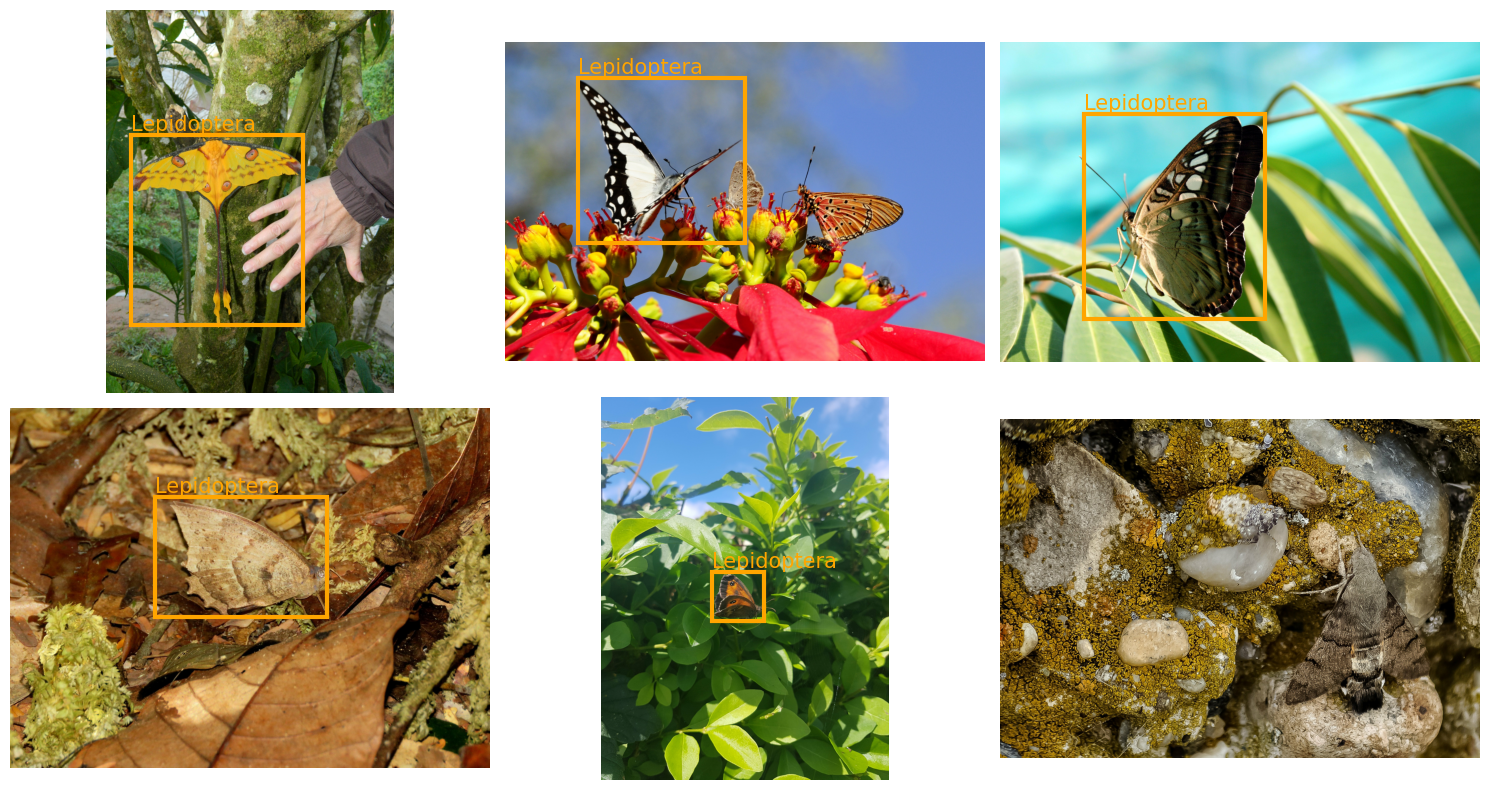

In [13]:
# Assuming the number of images (len(examples)) is even
num_images = len(examples)
num_rows = 2
num_cols = num_images // num_rows  # Calculate columns based on even rows

# Create figure and axes with adjusted subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))  # Use subplots for grid

image_file_paths = glob.glob(f"{DATASET_PATH}/{random_label}/*.jpg")[:BATCH_SIZE]

# Iterate through images and responses
for idx, (file_path, response) in enumerate(zip(image_file_paths, responses)):
  # Calculate row and column index for each image
    row = idx // num_cols
    col = idx % num_cols

    image = tf.io.decode_jpeg(tf.io.read_file(file_path)).numpy()

    height, width = image.shape[:2]

    # Display the image on specific subplot
    axes[row, col].imshow(image)

    # Extract bounding boxes
    objs = extract_objs(response, width, height)

    for obj in objs:
        x1, y1, x2, y2 = obj['xyxy']

        # Calculate box dimensions
        box_width = x2 - x1
        box_height = y2 - y1

        # Create Rectangle patch
        rect = patches.Rectangle(
            (x1, y1), box_width, box_height, linewidth=3, edgecolor='orange', facecolor='none')

        # Add the patch to the specific subplot
        axes[row, col].add_patch(rect)

        # Adjust text positioning based on box dimensions
        text_x = x1 - box_width / 10  # Offset slightly from top-left corner
        text_y = y1 - box_height / 10  # Offset slightly from top-left corner

        # Ensure text stays within the box
        text_x = max(text_x, x1)  # Minimum x-position to avoid clipping on left
        text_y = max(text_y, y1)  # Minimum y-position to avoid clipping on bottom

        text_str = obj['name']  # Assuming label is in the obj dictionary
        
        # Add text with specific positioning and clipping
        axes[row, col].text(
            text_x, 
            text_y, 
            text_str, 
            ha='left', 
            va='bottom', 
            fontsize=15, 
            color='orange')

# Turn off axis for all subplots
for row in range(num_rows):
    for col in range(num_cols):
        axes[row, col].axis('off')

# Adjust layout (optional)
plt.tight_layout()

plt.show()


# References

1. [Fine tuning Paligemma](https://www.kaggle.com/code/nilaychauhan/fine-tune-paligemma-with-jax/notebook)
2. [Hugging Face Demo App](https://huggingface.co/spaces/google/paligemma-hf/blob/main/app.py)
3. [Big Vision Paligemma](https://github.com/google-research/big_vision/tree/main/big_vision/configs/proj/paligemma)